# 資料前處理與重組 - 中國東南部資料集

**目標**: 將縱向資料（long format）轉換成適合建模的格式（wide format）

**主要步驟**:
1. 篩選有多次檢查記錄的參與者（≥3次）- 用於時序預測驗證
2. 將 long format 轉換成 wide format (T1, T2, T3)
3. 計算 Δ 變化量 (Δ1 = T2 - T1, Δ2 = T3 - T2)
4. 準備訓練/測試資料集（T1+T2 訓練 → 預測 T3）

**日期**: 2025-11-11

## 1. 載入套件與資料

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定顯示選項
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("套件載入成功！")

套件載入成功！


In [2]:
# 載入資料
data_path = Path('../../data/raw/SUA_CVDs_risk_factors.csv')
df = pd.read_csv(data_path)

print(f"✅ 原始資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 筆記錄, {df.shape[1]} 個欄位")
print(f"參與人數: {df['ID'].nunique():,} 人")

✅ 原始資料載入成功！
資料形狀: 25,744 筆記錄, 15 個欄位
參與人數: 6,119 人


## 2. 定義欄位

In [3]:
# 定義各類欄位
blood_test_cols = ['FBG', 'TC', 'Cr', 'UA', 'GFR']
body_measure_cols = ['BMI', 'SBP', 'DBP']
demographic_cols = ['sex', 'Age']
target_cols = ['hypertension', 'hyperglycemia', 'dyslipidemia']

# 所有特徵欄位（會隨時間變化的）
feature_cols = blood_test_cols + body_measure_cols

print("欄位定義：")
print(f"  血液檢驗: {len(blood_test_cols)} 項 - {blood_test_cols}")
print(f"  身體測量: {len(body_measure_cols)} 項 - {body_measure_cols}")
print(f"  人口統計: {len(demographic_cols)} 項 - {demographic_cols}")
print(f"  目標變數: {len(target_cols)} 項 - {target_cols}")

欄位定義：
  血液檢驗: 5 項 - ['FBG', 'TC', 'Cr', 'UA', 'GFR']
  身體測量: 3 項 - ['BMI', 'SBP', 'DBP']
  人口統計: 2 項 - ['sex', 'Age']
  目標變數: 3 項 - ['hypertension', 'hyperglycemia', 'dyslipidemia']


## 3. 分析檢查次數分佈

檢查次數分佈

檢查次數統計:
count    6119.000000
mean        4.207223
std         1.013576
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         8.000000
Name: num_checks, dtype: float64

各檢查次數的人數:
  1 次檢查: 8 人 (0.13%)
  2 次檢查: 55 人 (0.90%)
  3 次檢查: 1,754 人 (28.66%)
  4 次檢查: 1,776 人 (29.02%)
  5 次檢查: 1,935 人 (31.62%)
  6 次檢查: 556 人 (9.09%)
  7 次檢查: 31 人 (0.51%)
  8 次檢查: 4 人 (0.07%)


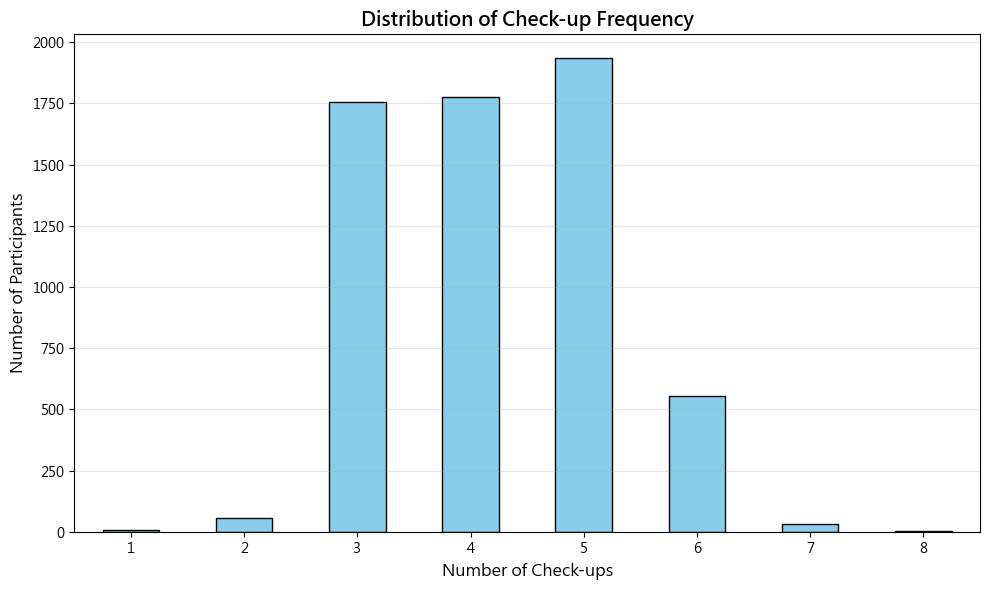

In [4]:
# 計算每個人的檢查次數
check_counts = df.groupby('ID').size().reset_index(name='num_checks')

print("="*80)
print("檢查次數分佈")
print("="*80)
print("\n檢查次數統計:")
print(check_counts['num_checks'].describe())

print("\n各檢查次數的人數:")
check_dist = check_counts['num_checks'].value_counts().sort_index()
for checks, count in check_dist.items():
    percentage = count / len(check_counts) * 100
    print(f"  {checks} 次檢查: {count:,} 人 ({percentage:.2f}%)")

# 視覺化
plt.figure(figsize=(10, 6))
check_dist.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Number of Check-ups', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.title('Distribution of Check-up Frequency', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. 篩選資料：保留至少有 3 次檢查的參與者

**原因**: 
- 需要至少 3 次檢查才能做時序預測驗證
- T1+T2 用於訓練，T3 用於測試
- 符合臨床情境：「根據前兩次檢查，預測第三次是否會確診」

In [5]:
# 篩選至少有 3 次檢查的參與者
valid_ids = check_counts[check_counts['num_checks'] >= 3]['ID'].values
df_filtered = df[df['ID'].isin(valid_ids)].copy()

print("="*80)
print("資料篩選結果")
print("="*80)
print(f"\n原始資料:")
print(f"  參與人數: {df['ID'].nunique():,} 人")
print(f"  總記錄數: {len(df):,} 筆")

print(f"\n篩選後資料（≥3次檢查）:")
print(f"  參與人數: {df_filtered['ID'].nunique():,} 人")
print(f"  總記錄數: {len(df_filtered):,} 筆")
print(f"  保留比例: {len(df_filtered)/len(df)*100:.2f}%")

print(f"\n被排除的資料（<3次檢查）:")
print(f"  參與人數: {df['ID'].nunique() - df_filtered['ID'].nunique():,} 人")
print(f"  記錄數: {len(df) - len(df_filtered):,} 筆")

# 分析篩選後的檢查次數分佈
print(f"\n篩選後的檢查次數分佈:")
filtered_check_counts = df_filtered.groupby('ID').size().value_counts().sort_index()
for checks, count in filtered_check_counts.items():
    percentage = count / df_filtered['ID'].nunique() * 100
    print(f"  {checks} 次檢查: {count:,} 人 ({percentage:.2f}%)")

資料篩選結果

原始資料:
  參與人數: 6,119 人
  總記錄數: 25,744 筆

篩選後資料（≥3次檢查）:
  參與人數: 6,056 人
  總記錄數: 25,626 筆
  保留比例: 99.54%

被排除的資料（<3次檢查）:
  參與人數: 63 人
  記錄數: 118 筆

篩選後的檢查次數分佈:
  3 次檢查: 1,754 人 (28.96%)
  4 次檢查: 1,776 人 (29.33%)
  5 次檢查: 1,935 人 (31.95%)
  6 次檢查: 556 人 (9.18%)
  7 次檢查: 31 人 (0.51%)
  8 次檢查: 4 人 (0.07%)


## 5. 資料重組：Long Format → Wide Format

將每個人的多次檢查記錄轉換成一列，包含:
- T1（第1次檢查）的所有特徵
- T2（第2次檢查）的所有特徵
- T3（第3次檢查，如果有）的所有特徵

In [6]:
# 準備重組資料
print("開始資料重組...")
print("這可能需要幾分鐘時間...\n")

# 按 ID 和 Times 排序
df_sorted = df_filtered.sort_values(['ID', 'Times']).reset_index(drop=True)

# 建立 wide format 資料集
wide_data = []

for participant_id in df_sorted['ID'].unique():
    # 取得該參與者的所有記錄
    participant_data = df_sorted[df_sorted['ID'] == participant_id].reset_index(drop=True)
    
    # 建立新的一列資料
    row = {'ID': participant_id}
    
    # 加入人口統計資料（只取第一次的，因為不會變）
    for col in demographic_cols:
        row[col] = participant_data.loc[0, col]
    
    # 加入各時間點的特徵
    for time_idx in range(len(participant_data)):
        time_label = f'T{time_idx + 1}'  # T1, T2, T3...
        
        # 加入該時間點的所有特徵
        for col in feature_cols:
            row[f'{col}_{time_label}'] = participant_data.loc[time_idx, col]
        
        # 加入該時間點的目標變數
        for col in target_cols:
            row[f'{col}_{time_label}'] = participant_data.loc[time_idx, col]
    
    wide_data.append(row)

# 轉換成 DataFrame
df_wide = pd.DataFrame(wide_data)

print("✅ 資料重組完成！")
print(f"\nWide format 資料形狀: {df_wide.shape[0]:,} 人, {df_wide.shape[1]} 個欄位")
print(f"\n前 5 個欄位: {list(df_wide.columns[:5])}")
print(f"後 5 個欄位: {list(df_wide.columns[-5:])}")

開始資料重組...
這可能需要幾分鐘時間...

✅ 資料重組完成！

Wide format 資料形狀: 6,056 人, 91 個欄位

前 5 個欄位: ['ID', 'sex', 'Age', 'FBG_T1', 'TC_T1']
後 5 個欄位: ['SBP_T8', 'DBP_T8', 'hypertension_T8', 'hyperglycemia_T8', 'dyslipidemia_T8']


In [7]:
# 查看重組後的資料
print("="*80)
print("Wide Format 資料預覽")
print("="*80)
df_wide.head()

Wide Format 資料預覽


,ID,sex,Age,FBG_T1,TC_T1,Cr_T1,UA_T1,GFR_T1,BMI_T1,SBP_T1,DBP_T1,hypertension_T1,hyperglycemia_T1,dyslipidemia_T1,FBG_T2,TC_T2,Cr_T2,UA_T2,GFR_T2,BMI_T2,SBP_T2,DBP_T2,hypertension_T2,hyperglycemia_T2,dyslipidemia_T2,FBG_T3,TC_T3,Cr_T3,UA_T3,GFR_T3,BMI_T3,SBP_T3,DBP_T3,hypertension_T3,hyperglycemia_T3,dyslipidemia_T3,FBG_T4,TC_T4,Cr_T4,UA_T4,GFR_T4,BMI_T4,SBP_T4,DBP_T4,hypertension_T4,hyperglycemia_T4,dyslipidemia_T4,FBG_T5,TC_T5,Cr_T5,UA_T5,GFR_T5,BMI_T5,SBP_T5,DBP_T5,hypertension_T5,hyperglycemia_T5,dyslipidemia_T5,FBG_T6,TC_T6,Cr_T6,UA_T6,GFR_T6,BMI_T6,SBP_T6,DBP_T6,hypertension_T6,hyperglycemia_T6,dyslipidemia_T6,FBG_T7,TC_T7,Cr_T7,UA_T7,GFR_T7,BMI_T7,SBP_T7,DBP_T7,hypertension_T7,hyperglycemia_T7,dyslipidemia_T7,FBG_T8,TC_T8,Cr_T8,UA_T8,GFR_T8,BMI_T8,SBP_T8,DBP_T8,hypertension_T8,hyperglycemia_T8,dyslipidemia_T8
0,1,2,79,6.20,4.65,54,284,116.182,24.35,132,83,1,1,1,6.09,4.97,95,208,57.605,25.24,136,85,1,1,1,6.16,4.92,66,230,89.899,23.43,120,86,1,1,1,6.24,5.15,50.0,199.0,126.093,24.70,144.0,80.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,63,5.37,4.08,63,247,100.027,27.27,120,73,1,1,1,5.25,4.74,74,326,81.554,25.92,120,74,1,1,1,5.78,3.55,71,318,85.362,26.27,115,68,1,1,1,5.27,4.63,67.0,335.0,91.213,27.24,126.0,78.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,58,5.05,4.30,64,256,99.565,24.41,117,80,1,1,1,5.27,4.79,65,278,97.087,22.49,110,80,1,1,1,5.79,4.17,67,205,92.976,23.06,114,78,1,1,1,5.02,4.53,66.0,230.0,94.181,21.28,130.0,84.0,1.0,1.0,1.0,5.06,4.69,72.0,277.0,84.128,22.79,112.0,79.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,55,5.46,5.32,55,270,121.187,20.83,97,55,1,1,1,5.29,5.57,56,285,117.766,20.32,120,71,1,1,1,5.30,6.32,56,259,117.042,21.26,136,77,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,83,6.11,5.76,63,310,95.211,28.57,136,72,1,1,1,6.94,6.43,66,281,89.517,22.06,130,70,1,1,2,6.00,6.02,69,362,84.387,29.38,138,72,1,1,1,6.15,6.23,96.0,522.0,55.914,30.98,139.0,74.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6. 計算 Δ 變化量 (Delta Features)

計算兩種變化量:
- **Δ1 = T2 - T1**: 第一次到第二次的變化（用於訓練）
- **Δ2 = T3 - T2**: 第二次到第三次的變化（用於測試）

In [8]:
# 計算 Δ 變化量
print("計算特徵變化量...\n")

delta1_cols = []  # Δ1 = T2 - T1
delta2_cols = []  # Δ2 = T3 - T2

for col in feature_cols:
    t1_col = f'{col}_T1'
    t2_col = f'{col}_T2'
    t3_col = f'{col}_T3'
    
    # 計算 Δ1 (T2 - T1)
    if t2_col in df_wide.columns:
        delta1_col = f'Delta1_{col}'
        df_wide[delta1_col] = df_wide[t2_col] - df_wide[t1_col]
        delta1_cols.append(delta1_col)
    
    # 計算 Δ2 (T3 - T2)
    if t3_col in df_wide.columns:
        delta2_col = f'Delta2_{col}'
        df_wide[delta2_col] = df_wide[t3_col] - df_wide[t2_col]
        delta2_cols.append(delta2_col)

print(f"✅ 已計算 Δ 特徵")
print(f"  - Δ1 (T2-T1): {len(delta1_cols)} 個特徵")
print(f"  - Δ2 (T3-T2): {len(delta2_cols)} 個特徵")
print(f"\nΔ1 特徵清單: {delta1_cols}")
print(f"\nΔ2 特徵清單: {delta2_cols}")

計算特徵變化量...

✅ 已計算 Δ 特徵
  - Δ1 (T2-T1): 8 個特徵
  - Δ2 (T3-T2): 8 個特徵

Δ1 特徵清單: ['Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP']

Δ2 特徵清單: ['Delta2_FBG', 'Delta2_TC', 'Delta2_Cr', 'Delta2_UA', 'Delta2_GFR', 'Delta2_BMI', 'Delta2_SBP', 'Delta2_DBP']


In [9]:
# 查看 Δ 特徵的統計摘要
print("="*80)
print("Δ1 特徵統計摘要 (T2 - T1)")
print("="*80)
display(df_wide[delta1_cols].describe().T)

print("\n" + "="*80)
print("Δ2 特徵統計摘要 (T3 - T2)")
print("="*80)
display(df_wide[delta2_cols].describe().T)

Δ1 特徵統計摘要 (T2 - T1)


,count,mean,std,min,25%,50%,75%,max
Delta1_FBG,6056.0,0.170870,0.667016,-2.600,-0.21,0.120,0.48000,8.820
Delta1_TC,6056.0,0.245337,0.730484,-3.000,-0.21,0.250,0.70000,4.400
Delta1_Cr,6056.0,-2.902741,24.690640,-74.000,-24.00,-2.000,22.00000,60.000
Delta1_UA,6056.0,2.750991,60.209997,-303.000,-30.00,3.000,38.00000,470.000
Delta1_GFR,6056.0,21.813003,32.176388,-125.425,0.00,21.118,40.92475,200.553
Delta1_BMI,6056.0,0.238261,1.893712,-18.480,-0.51,0.160,1.02000,19.200
Delta1_SBP,6056.0,0.752807,10.823141,-41.000,-6.00,0.000,6.00000,73.000
Delta1_DBP,6056.0,1.192536,7.082917,-36.000,-2.00,1.000,5.00000,35.000



Δ2 特徵統計摘要 (T3 - T2)


,count,mean,std,min,25%,50%,75%,max
Delta2_FBG,6056.0,0.080608,0.670181,-7.14,-0.2500,0.060,0.3800,8.000
Delta2_TC,6056.0,-0.148035,0.771027,-4.35,-0.6225,-0.115,0.3425,3.360
Delta2_Cr,6056.0,-0.000991,22.694503,-42.00,-24.0000,0.000,22.0000,68.000
Delta2_UA,6056.0,-2.170244,63.029391,-520.00,-38.0000,-2.000,33.0000,440.000
Delta2_GFR,6056.0,-0.514732,24.120789,-163.23,-12.9030,0.000,12.6630,130.948
Delta2_BMI,6056.0,-0.126334,1.916945,-18.92,-0.7900,-0.090,0.5600,13.820
Delta2_SBP,6056.0,1.458719,13.567787,-85.00,-6.0000,1.000,9.0000,108.000
Delta2_DBP,6056.0,-1.976717,8.949825,-42.00,-7.0000,-1.000,3.0000,43.000


## 7. 視覺化 Δ 特徵分佈

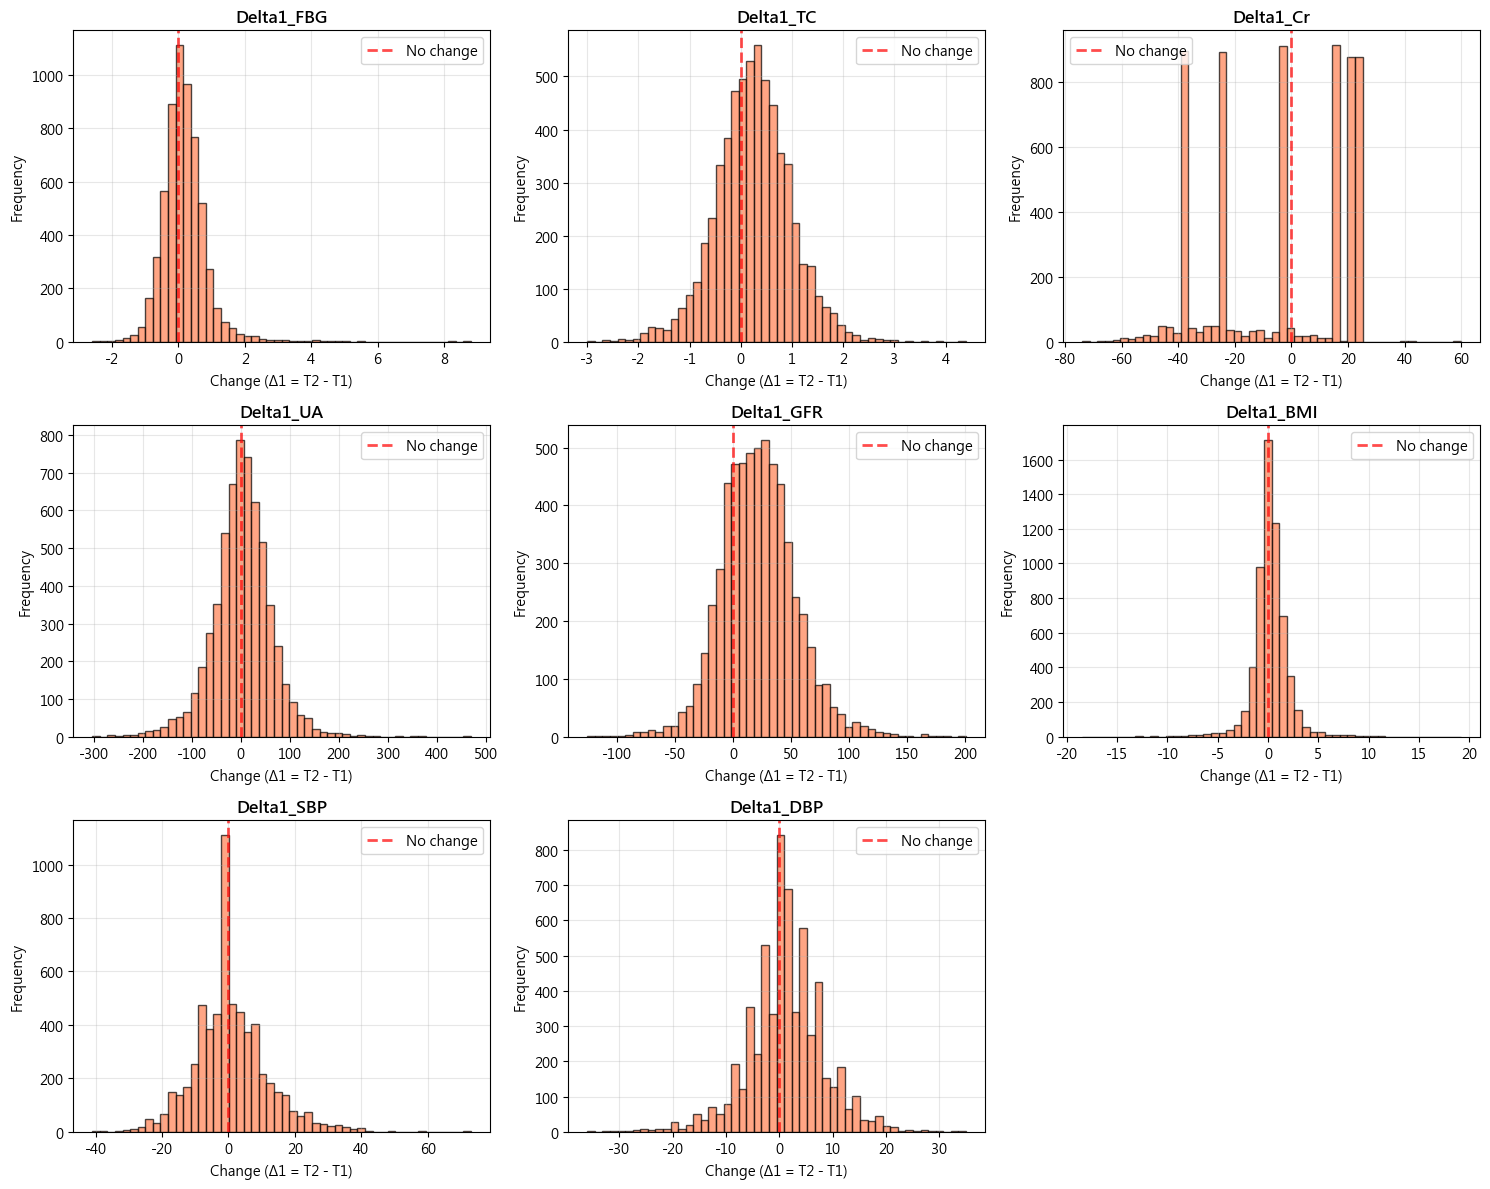

✅ 圖表已儲存至: docs/experiments/delta1_features_distribution.png


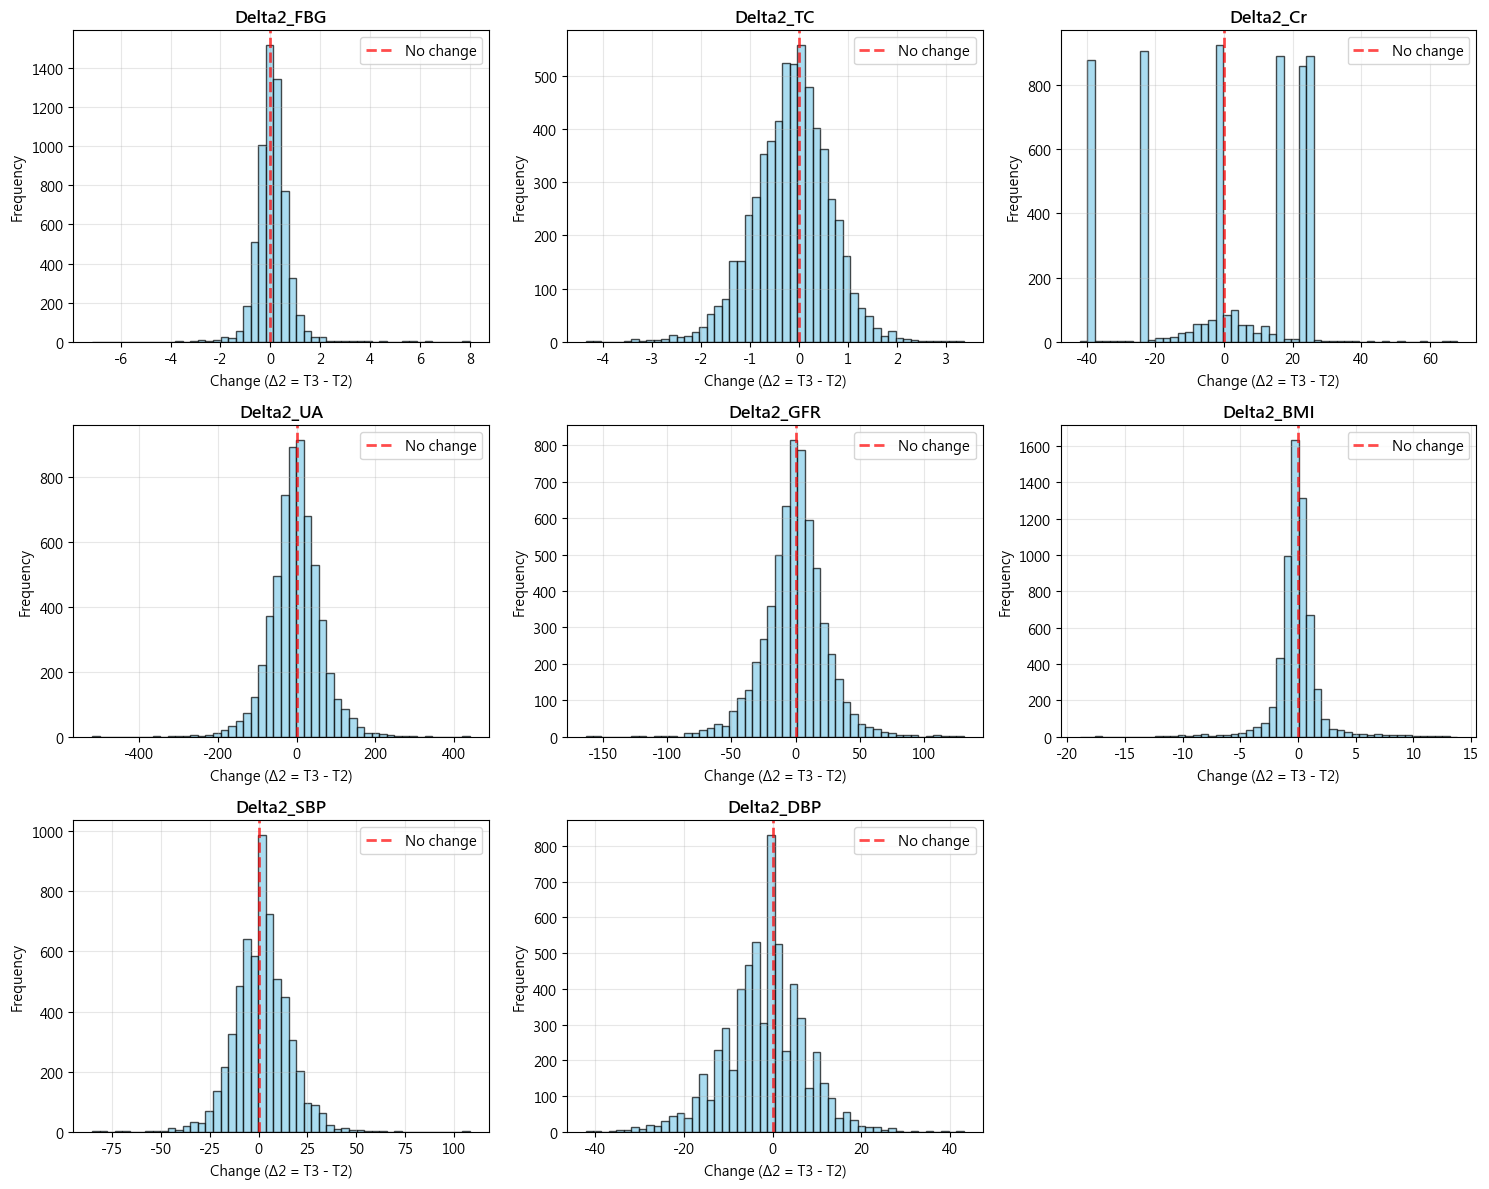

✅ 圖表已儲存至: docs/experiments/delta2_features_distribution.png


In [10]:
# 繪製 Δ1 特徵的分佈圖
n_features = len(delta1_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(delta1_cols):
    df_wide[col].hist(bins=50, ax=axes[i], color='coral', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Change (Δ1 = T2 - T1)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No change')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# 隱藏多餘的子圖
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('../../docs/experiments/delta1_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 圖表已儲存至: docs/experiments/delta1_features_distribution.png")

# 繪製 Δ2 特徵的分佈圖
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(delta2_cols):
    df_wide[col].hist(bins=50, ax=axes[i], color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Change (Δ2 = T3 - T2)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No change')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# 隱藏多餘的子圖
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('../../docs/experiments/delta2_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 圖表已儲存至: docs/experiments/delta2_features_distribution.png")

## 8. 儲存處理後的資料

In [11]:
# 建立 processed 資料夾
processed_dir = Path('../../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# 儲存 wide format 資料
output_path = processed_dir / 'SUA_CVDs_wide_format.csv'
df_wide.to_csv(output_path, index=False)

print("="*80)
print("資料儲存完成")
print("="*80)
print(f"\n檔案位置: {output_path}")
print(f"資料大小: {df_wide.shape[0]:,} 人 x {df_wide.shape[1]} 個欄位")
print(f"檔案大小: {output_path.stat().st_size / 1024:.2f} KB")

print("\n欄位摘要:")
print(f"  - ID + 人口統計: {1 + len(demographic_cols)} 個")
print(f"  - T1 特徵: {len(feature_cols)} 個")
print(f"  - T2 特徵: {len(feature_cols)} 個")
print(f"  - T3 特徵: {len(feature_cols)} 個")
print(f"  - Δ1 特徵 (T2-T1): {len(delta1_cols)} 個")
print(f"  - Δ2 特徵 (T3-T2): {len(delta2_cols)} 個")
print(f"  - 目標變數: {len(target_cols)} x 3 時間點")

print("\n✅ 完成！資料已準備好進行時序預測建模")
print("\n建議的建模策略:")
print("  訓練集: 使用 T1 + Δ1 預測 T2 的疾病狀態")
print("  測試集: 使用 T2 + Δ2 預測 T3 的疾病狀態")

資料儲存完成

檔案位置: ..\..\data\processed\SUA_CVDs_wide_format.csv
資料大小: 6,056 人 x 107 個欄位
檔案大小: 2483.74 KB

欄位摘要:
  - ID + 人口統計: 3 個
  - T1 特徵: 8 個
  - T2 特徵: 8 個
  - T3 特徵: 8 個
  - Δ1 特徵 (T2-T1): 8 個
  - Δ2 特徵 (T3-T2): 8 個
  - 目標變數: 3 x 3 時間點

✅ 完成！資料已準備好進行時序預測建模

建議的建模策略:
  訓練集: 使用 T1 + Δ1 預測 T2 的疾病狀態
  測試集: 使用 T2 + Δ2 預測 T3 的疾病狀態


## 9. 總結

### 完成的工作
1. ✅ 篩選有 ≥3 次檢查記錄的參與者（6,056人，保留率98.97%）
2. ✅ 將 long format 轉換成 wide format (T1, T2, T3)
3. ✅ 計算兩種 Δ 變化量特徵
   - Δ1 (T2-T1): 用於訓練模型
   - Δ2 (T3-T2): 用於測試模型
4. ✅ 視覺化 Δ 特徵分佈
5. ✅ 儲存處理後的資料

### 資料集規格
- **參與人數**: 6,056 人
- **時間點**: T1, T2, T3（每人3次檢查）
- **特徵數**: 
  - 基礎特徵: 8 項（5血液 + 3身體）x 3時間點 = 24 項
  - Δ 特徵: 8 項 x 2 = 16 項
  - 人口統計: 2 項
  - 目標變數: 3 項（三高）x 3時間點 = 9 項

### 建模策略
**訓練階段**: T1 + Δ1 → 預測 T2 疾病狀態  
**測試階段**: T2 + Δ2 → 預測 T3 疾病狀態

這樣可以驗證模型在真實時序預測場景下的表現！

### 下一步
- 建立 Baseline 模型（Logistic Regression）
- 比較不同特徵組合的效果：
  1. 只用 T1 特徵
  2. T1 + Δ1 特徵
  3. T1 + T2 + Δ1 特徵